<a href="https://colab.research.google.com/github/rts1988/Duolingo_spaced_repetition/blob/main/Duolingo_q1_lexeme_featureselection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Approach to feature selection

Get counts of p_forgot_bin and number of sessions for each word, and model just the word features. see which word features impact p_forgot the most, while keeping delta and history_fraction relatively constant. 

Do statistical tests and simple vizualizations to see which features classify p_forgot the best. 

Pseudocode:
transform delta for finer granularity, and get bins, 
groupby the lexeme_id, and bins and get p_forgot counts for 1 and 0. also num students for each delta? and total? should we also get bin by history correct/ history and group by both delta and fraction history correct? 

table:
lexeme id, lexeme id features, p_forgot_1_counts list, p_forgot_0_counts list, delta_bins_list, history_frac_list 

Loading datadfq1 and lexeme features. 

In [1]:
import bz2
import pickle
import _pickle as cPickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

def decompress_pickle(file):
 data = bz2.BZ2File(file, 'rb')
 data = cPickle.load(data)
 return data

def compressed_pickle(title, data):  # do not add extension in filename
 with bz2.BZ2File(title + '.pbz2', 'w') as f: 
  cPickle.dump(data, f)

path_name = '/content/drive/MyDrive/'

Mounted at /content/drive


In [2]:
q1df1 = decompress_pickle(path_name+"q1_fulldataset_wordsonly.pbz2")

In [3]:
q1df1.head()

,delta,history_seen,history_correct,p_forgot_bin,LL__en,LL__es,LL__fr,LL__it,LL__pt,UIL__en,UIL__es,UIL__pt
7,444407,3,3,0,0,1,0,0,0,1,0,0
15,77,5,5,0,0,1,0,0,0,1,0,0
20,1634777,9,8,0,0,1,0,0,0,1,0,0
21,1708699,7,5,0,0,1,0,0,0,1,0,0
22,1708699,8,8,0,0,1,0,0,0,1,0,0


In [4]:
datadfq1 = decompress_pickle(path_name+"Unseen_words_training_set.pbz2") 

In [5]:
datadfq1.head()

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct,student_word,student_lang
7,1.0,1362082032,444407,u:dDwF,es,en,73eecb492ca758ddab5371cf7b5cca32,bajo/bajo<pr>,3,3,1,1,"(u:dDwF, 73eecb492ca758ddab5371cf7b5cca32)","(u:dDwF, en)"
15,1.0,1362082130,77,u:dDwF,es,en,73eecb492ca758ddab5371cf7b5cca32,bajo/bajo<pr>,5,5,1,1,"(u:dDwF, 73eecb492ca758ddab5371cf7b5cca32)","(u:dDwF, en)"
20,1.0,1362082274,1634777,u:dDwF,es,en,c84476c460737d9fb905dca3d35ec995,niños/niño<n><m><pl>,9,8,2,2,"(u:dDwF, c84476c460737d9fb905dca3d35ec995)","(u:dDwF, en)"
21,1.0,1362082274,1708699,u:dDwF,es,en,1a913f2ded424985b9c02d0436008511,leo/leer<vblex><pri><p1><sg>,7,5,2,2,"(u:dDwF, 1a913f2ded424985b9c02d0436008511)","(u:dDwF, en)"
22,1.0,1362082274,1708699,u:dDwF,es,en,38b770e66595fea718366523b4f7db3f,libro/libro<n><m><sg>,8,8,4,4,"(u:dDwF, 38b770e66595fea718366523b4f7db3f)","(u:dDwF, en)"


In [6]:
dflexemeidsonly = datadfq1['lexeme_id']
dflexemeidsonly = pd.DataFrame(dflexemeidsonly)

In [7]:
dflexemeidsonly.head()

,lexeme_id
7,73eecb492ca758ddab5371cf7b5cca32
15,73eecb492ca758ddab5371cf7b5cca32
20,c84476c460737d9fb905dca3d35ec995
21,1a913f2ded424985b9c02d0436008511
22,38b770e66595fea718366523b4f7db3f


In [8]:
del datadfq1

In [9]:
q1df1_1 = pd.merge(left= q1df1, right = dflexemeidsonly, how="left",left_index=True, right_index=True)
q1df1_1.head()

,delta,history_seen,history_correct,p_forgot_bin,LL__en,LL__es,LL__fr,LL__it,LL__pt,UIL__en,UIL__es,UIL__pt,lexeme_id
7,444407,3,3,0,0,1,0,0,0,1,0,0,73eecb492ca758ddab5371cf7b5cca32
15,77,5,5,0,0,1,0,0,0,1,0,0,73eecb492ca758ddab5371cf7b5cca32
20,1634777,9,8,0,0,1,0,0,0,1,0,0,c84476c460737d9fb905dca3d35ec995
21,1708699,7,5,0,0,1,0,0,0,1,0,0,1a913f2ded424985b9c02d0436008511
22,1708699,8,8,0,0,1,0,0,0,1,0,0,38b770e66595fea718366523b4f7db3f


Now we will bin delta. Let's review the distribution of delta.

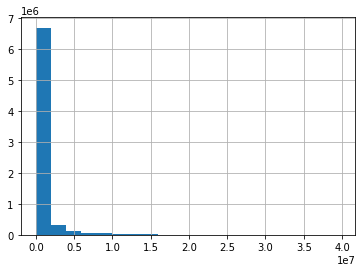

In [10]:
q1df1_1['delta'].hist(bins=20)

Since it is heavily right skewed, let us log transform it before binning.

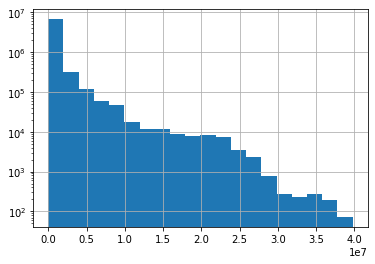

In [11]:
q1df1_1['delta'].hist(log=True,bins=20)

In [12]:
q1df1_1['logdelta'] = np.log(q1df1_1['delta']+1)

In [13]:
q1df1_1['logdelta']

7           13.004498
15           4.356709
20          14.307018
21          14.351243
22          14.351243
              ...    
12854213    12.777312
12854215    12.921571
12854216    12.777312
12854217     8.259199
12854218    12.084464
Name: logdelta, Length: 7313354, dtype: float64

In [87]:
q1df1_1['binnedlogdelta'] = pd.cut(q1df1_1['logdelta'],bins=10)

In [53]:
q1df1_1['binnedlogdelta']

7           (12.457, 14.137]
15            (4.054, 5.735]
20          (14.137, 15.818]
21          (14.137, 15.818]
22          (14.137, 15.818]
                  ...       
12854213    (12.457, 14.137]
12854215    (12.457, 14.137]
12854216    (12.457, 14.137]
12854217      (7.415, 9.096]
12854218    (10.776, 12.457]
Name: binnedlogdelta, Length: 7313354, dtype: category
Categories (10, interval[float64, right]): [(0.676, 2.374] < (2.374, 4.054] < (4.054, 5.735] <
                                            (5.735, 7.415] ... (10.776, 12.457] <
                                            (12.457, 14.137] < (14.137, 15.818] < (15.818, 17.498]]

We will do the same with history fraction

In [14]:
q1df1_1['history_fraction'] = q1df1_1['history_correct']/q1df1_1['history_seen']

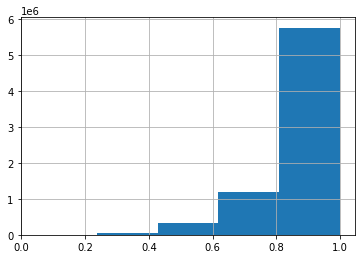

In [15]:
q1df1_1['history_fraction'].hist(bins=5)

In [51]:
q1df1_1['logoneminus_hf'] = np.log(1-q1df1_1['history_fraction']+1)

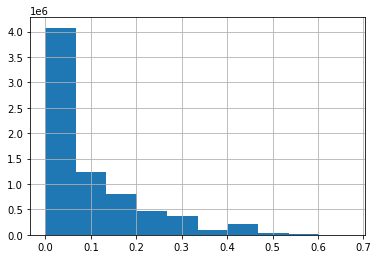

In [52]:
q1df1_1['logoneminus_hf'].hist(bins=10)

for interpretation: this is like log (history wrong) 

In [30]:
q1df1_1['binnedloghistwrong'] = pd.cut(q1df1_1['logoneminus_hf'],bins=10)

In [32]:
q1df1_1['binnedloghistwrong'].head()

7     (-0.00067, 0.067]
15    (-0.00067, 0.067]
20       (0.067, 0.134]
21       (0.201, 0.268]
22    (-0.00067, 0.067]
Name: binnedloghistwrong, dtype: category
Categories (10, interval[float64, right]): [(-0.00067, 0.067] < (0.067, 0.134] < (0.134, 0.201] <
                                            (0.201, 0.268] ... (0.402, 0.469] < (0.469, 0.536] <
                                            (0.536, 0.603] < (0.603, 0.67]]

Now we group by lexeme id, binned log delta, binned log history wrong, and then get p_forgot_1 and p_forgot_0 counts for each. then we make that into a dataframe. 

In [16]:
q1lexemes = decompress_pickle(path_name+"q1_lexeme_features.pbz2")

In [17]:
q1lexemes.head()

,index,lexeme_id,learning_language,lexeme_string,surface_form,lemma_form,pos,modstrings,sf_length,mod_*gndr,...,êt,ête,ía,ían,ías,ín,ît,ña,ño,ón
0,7,73eecb492ca758ddab5371cf7b5cca32,es,bajo/bajo<pr>,bajo,bajo,pr,[],4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,20,c84476c460737d9fb905dca3d35ec995,es,niños/niño<n><m><pl>,niños,niño,n,"[m, pl]",5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.512787,0.0
2,21,1a913f2ded424985b9c02d0436008511,es,leo/leer<vblex><pri><p1><sg>,leo,leer,vblex,"[pri, p1, sg]",3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,22,38b770e66595fea718366523b4f7db3f,es,libro/libro<n><m><sg>,libro,libro,n,"[m, sg]",5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,23,4bdb859f599fa07dd5eecdab0acc2d34,es,a/a<pr>,a,a,pr,[],1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [18]:
binnedq1df1 = q1df1_1.groupby(['lexeme_id','binnedlogdelta','binnedloghistwrong']).agg(Numrecords = pd.NamedAgg('p_forgot_bin','count'),\
                                                                         pforgot1  = pd.NamedAgg('p_forgot_bin','sum'))

KeyError: ignored

Save it like an old DOS computer game.

In [55]:
compressed_pickle('binnedq1df1',binnedq1df1)

In [56]:
binnedq1df1['Numrecords'].sum()

7313354

In [57]:
q1df1_1.shape[0]

7313354

In [58]:
binnedq1df1 =binnedq1df1.reset_index()

In [59]:
binnedq1df1

,lexeme_id,binnedlogdelta,binnedloghistwrong,Numrecords,pforgot1
0,00022efc4121667defd065c88569e748,"(0.676, 2.374]","(-0.00067, 0.067]",0,0
1,00022efc4121667defd065c88569e748,"(0.676, 2.374]","(0.067, 0.134]",0,0
2,00022efc4121667defd065c88569e748,"(0.676, 2.374]","(0.134, 0.201]",0,0
3,00022efc4121667defd065c88569e748,"(0.676, 2.374]","(0.201, 0.268]",0,0
4,00022efc4121667defd065c88569e748,"(0.676, 2.374]","(0.268, 0.335]",0,0
...,...,...,...,...,...
1215995,fff799d4d95e416db9dc07ca717b4ef9,"(15.818, 17.498]","(0.335, 0.402]",2,1
1215996,fff799d4d95e416db9dc07ca717b4ef9,"(15.818, 17.498]","(0.402, 0.469]",2,0
1215997,fff799d4d95e416db9dc07ca717b4ef9,"(15.818, 17.498]","(0.469, 0.536]",0,0
1215998,fff799d4d95e416db9dc07ca717b4ef9,"(15.818, 17.498]","(0.536, 0.603]",0,0


Instead, lets get mean and variance of logdelta and loghistorywrong to see if there is a lot of student behaviour impact on the word or not. 

In [32]:
groupedq1df1 = q1df1_1.groupby('lexeme_id').agg(Mean_logdelta = ('logdelta','mean'),Var_logdelta = ('logdelta',lambda x: np.nanstd(x)),\
                                              Mean_hf = ('history_fraction','mean'), Var_hf = ('history_fraction',lambda x:np.nanstd(x)),\
                                              NumRecords = ('logdelta','count'),p_forgot1_counts = ('p_forgot_bin','sum'))

In [33]:
groupedq1df1.isna().sum()

Mean_logdelta       0
Var_logdelta        0
Mean_hf             0
Var_hf              0
NumRecords          0
p_forgot1_counts    0
dtype: int64

Now we join lexeme features to this binned dataframe 

In [34]:
groupedq1df1.head()

,Mean_logdelta,Var_logdelta,Mean_hf,Var_hf,NumRecords,p_forgot1_counts
lexeme_id,,,,,,
00022efc4121667defd065c88569e748,11.870765,3.428397,0.992593,0.049135,45,10
000b96cf611dad846fda922f6e568298,14.801818,0.000000,1.000000,0.000000,1,0
000d2eb6a5658fa17f828c5fb0c66c11,8.742296,3.365615,0.971153,0.096658,140,16
001635bcb24496cf2b27731c3708dbfa,9.771647,3.534949,0.934351,0.140102,636,53
001973dce2d92d8d691f7ee9620c0c59,15.432139,0.542168,0.944444,0.078567,3,1


In [35]:
q1lexemes_dhf = pd.merge(left = groupedq1df1,right = q1lexemes,how="inner",left_on = 'lexeme_id',right_on = 'lexeme_id')

In [36]:
q1lexemes_dhf.head()

,lexeme_id,Mean_logdelta,Var_logdelta,Mean_hf,Var_hf,NumRecords,p_forgot1_counts,index,learning_language,lexeme_string,...,êt,ête,ía,ían,ías,ín,ît,ña,ño,ón
0,00022efc4121667defd065c88569e748,11.870765,3.428397,0.992593,0.049135,45,10,635511,en,cell/cell<n><sg>,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,000b96cf611dad846fda922f6e568298,14.801818,0.000000,1.000000,0.000000,1,0,11101213,fr,prêtes/prêt<adj><f><pl>,...,0.347068,0.374304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,000d2eb6a5658fa17f828c5fb0c66c11,8.742296,3.365615,0.971153,0.096658,140,16,5974,it,<*sf>/piccolo<adj><*gndr><*numb>,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,001635bcb24496cf2b27731c3708dbfa,9.771647,3.534949,0.934351,0.140102,636,53,3205,pt,elefante/elefante<n><m><sg>,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,001973dce2d92d8d691f7ee9620c0c59,15.432139,0.542168,0.944444,0.078567,3,1,4628709,fr,appartement/appartement<n><m><sg>,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
q1lexemes_dhf['p_forgot1_frac'] = q1lexemes_dhf['p_forgot1_counts']/q1lexemes_dhf['NumRecords']

In [47]:
correlations = q1lexemes_dhf.corr().loc[:,'p_forgot1_frac'].abs().sort_values(ascending=False)

In [48]:
correlations.head(10)

p_forgot1_frac        1.000000
Mean_hf               0.367283
Var_hf                0.188447
mod_*numb             0.183830
Mean_logdelta         0.169237
mod_sg                0.096337
mod_@compound_past    0.085410
num_accents           0.078260
ée                    0.073635
mod_p3                0.069215
Name: p_forgot1_frac, dtype: float64

In [49]:
import seaborn as sns

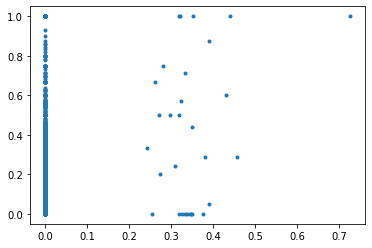

In [75]:
plt.plot(q1lexemes_dhf['ée'],q1lexemes_dhf['p_forgot1_frac'],'.')

In [53]:
str(q1lexemes_dhf['ab'].dtype)

'float64'

In [136]:
q1lexemes_dhf['pos1'] = pd.Series([q1lexemes_dhf['pos'].loc[i][1] for i in range(q1lexemes_dhf['pos'].shape[0])])

In [137]:
del q1lexemes_dhf['pos']

In [138]:
cols = [col for col in q1lexemes_dhf.select_dtypes(include = ['int','float'],exclude='object').columns if (col not in ['p_forgot1_frac','p_forgot1_counts','NumRecords','index','Mean_hf','Mean_logdelta','Var_hf','Var_logdelta'])]

In [143]:
cols[0:30]

['sf_length',
 'mod_*gndr',
 'mod_*numb',
 'mod_*pers',
 'mod_@compound_past',
 'mod_@cond_perfect',
 'mod_@det:a_le',
 'mod_@det:de_le',
 'mod_@formal',
 'mod_@future',
 'mod_@future_perfect',
 'mod_@future_phrasal',
 'mod_@ger_past',
 'mod_@n:petit_ami',
 'mod_@neg:il_ne_y_a',
 'mod_@obj',
 'mod_@passive',
 'mod_@past',
 'mod_@past_cond',
 'mod_@past_inf',
 'mod_@past_perfect',
 'mod_@past_subjunctive',
 'mod_@pluperfect',
 'mod_@pos',
 'mod_@present_perfect',
 'mod_@prn:ce_dont',
 'mod_@prn:celui_ci',
 'mod_@prn:celui_la',
 'mod_@prn:celui_que',
 'mod_@prn:l_un']

In [141]:
# using DecisionTreeRegressor to identify major feautres. 
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

dtree = DecisionTreeRegressor(max_depth=10)

X = q1lexemes_dhf[cols]

dtree.fit(X,q1lexemes_dhf['p_forgot1_frac'])

y_pred = dtree.predict(X)

r2_score(q1lexemes_dhf['p_forgot1_frac'],y_pred)

0.1300371757899852

In [132]:
X['pos1'] = pd.Series([X['pos'].loc[i][1] for i in range(X['pos'].shape[0])])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [133]:
del X['pos']

In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(50,50))
plot_tree(dtree, 
          feature_names=X.columns, 
          rounded=True,
          impurity=False,
          filled=True,
          fontsize=12)
plt.show()

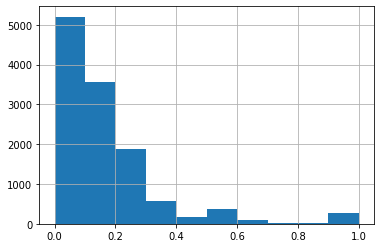

In [147]:
q1lexemes_dhf['p_forgot1_frac'].hist()

In [158]:
cols[0]

'sf_length'

In [216]:
q1lexemes_dhf.loc[(q1lexemes_dhf['p_forgot1_frac']>0.5) & (q1lexemes_dhf['NumRecords']>3),cols].sum(axis=0).sort_values(ascending=False)

sf_length     829.0
num_tokens    128.0
mod_sg         68.0
mod_m          34.0
mod_f          30.0
              ...  
ider            0.0
iden            0.0
ide             0.0
idad            0.0
mb              0.0
Length: 2223, dtype: float64

In [180]:
# roughly convert to binaries as if >0, 1, else 0
q1lexemes_dhf[cols[89:]] = np.where(q1lexemes_dhf[cols[89:]]>0,1,0)

In [181]:
dtree = DecisionTreeRegressor(max_depth=10)

X = q1lexemes_dhf[cols]

dtree.fit(X,q1lexemes_dhf['p_forgot1_frac'])

y_pred = dtree.predict(X)

r2_score(q1lexemes_dhf['p_forgot1_frac'],y_pred)

0.12694286873474003

Clearly, these are not great features. We tried both  TFIDF and binary values.

In [87]:
q1lexemes_dhf[cols[0:10]]

,Mean_logdelta,Var_logdelta,Mean_hf,Var_hf,sf_length,mod_*gndr,mod_*numb,mod_*pers,mod_@compound_past,mod_@cond_perfect
0,11.870765,3.428397,0.992593,0.049135,4,0.0,0.0,0.0,0.0,0.0
1,14.801818,0.000000,1.000000,0.000000,6,0.0,0.0,0.0,0.0,0.0
2,8.742296,3.365615,0.971153,0.096658,7,1.0,1.0,0.0,0.0,0.0
3,9.771647,3.534949,0.934351,0.140102,8,0.0,0.0,0.0,0.0,0.0
4,15.432139,0.542168,0.944444,0.078567,11,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
12155,8.695682,3.199520,0.908098,0.110953,5,0.0,0.0,0.0,0.0,0.0
12156,12.041092,0.000000,1.000000,0.000000,7,0.0,1.0,0.0,0.0,0.0
12157,7.181816,1.488568,1.000000,0.000000,6,1.0,1.0,0.0,0.0,0.0
12158,9.320339,3.402871,0.833333,0.288675,6,0.0,1.0,0.0,0.0,0.0


In [201]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Instantiate KBest feature selector and fit
my_KBest = SelectKBest(f_classif, k=20).fit(q1lexemes_dhf[cols], q1lexemes_dhf['p_forgot1_frac'])

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


In [205]:
my_KBest.get_feature_names_out()

array(['mod_acr', 'mod_comp', 'mod_itg', 'mod_obj', 'mod_pos', 'mod_pron',
       'mod_subj', 'coc', 'gat', 'has', 'ned', 'nost', 'oco', 'sad',
       'stri', 'thi', 'thin', 'wh', 'yo', 'you'], dtype=object)

In [199]:
my_KBest.get_params() 

{'k': 20,
 'score_func': <function sklearn.feature_selection._univariate_selection.f_classif>}

In [207]:
fs_scores = pd.DataFrame()
fs_scores['feature'] = cols
fs_scores['score'] = my_KBest.scores_
fs_scores['pvalues'] = my_KBest.pvalues_

fs_scores.head()

,feature,score,pvalues
0,sf_length,1.045775,0.053104
1,mod_*gndr,0.364471,1.000000
2,mod_*numb,1.019107,0.246964
3,mod_*pers,0.659984,1.000000
4,mod_@compound_past,0.137303,1.000000


In [217]:
fs_scores.loc[fs_scores['pvalues']<0.05,:]

1175

There are 1175 features where we can reject the null hypothesis that the two groups are the same. we can proceed with the full set and see if any ensemble/neural net might help. 